In [1]:
%pylab inline
plt.rcParams['image.cmap'] = 'viridis'

import h5py,os,sys
from flash_tools import *
root_dir = os.path.abspath(".") + "/../"
sys.path.append(root_dir)
import params

import seaborn as sns
sns.set_style("white")

/Users/hantke/Library/Python/2.7/lib/python/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


In [6]:
runs = range(252, 267+1)
# From Tomas' camera analysis (see google spreadsheet)
Z = [1055.9,1055.9,1055.9,1055.9,860.57,752.42,698.72,698.72,653.98,541.55,541.55,445.05,445.05,445.05,143.53,0.]

# Skip some runs, leave one for every Z position
runs = range(255, 267+1)
runs.remove(261)
runs.remove(263)
runs.remove(264)
# From Tomas' camera analysis (see google spreadsheet)
Z = [1055.9,860.57,752.42,698.72,698.72,653.98,541.55,445.05,143.53,0.]

nmuls = zeros(len(runs))
nhits = zeros(len(runs))
ntots = zeros(len(runs))
injzs = []
injxs = []
for i,r in enumerate(runs):
    mulscores = read_mulscores(run_nr=r)
    T = 5
    nmuls[i] = (mulscores > T).sum()
    ntots[i] = len(mulscores)    
    hitscores = read_hitscores(run_nr=r)
    T = 2000
    nhits[i] = (hitscores > T).sum()
    injxs.append(read_injx(run_nr=r))
    injzs.append(read_injz(run_nr=r))

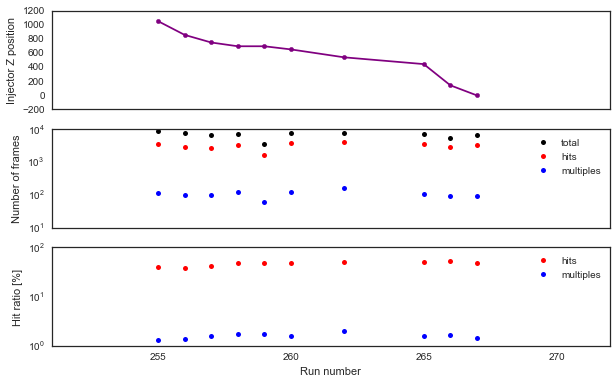

In [7]:
fig, (ax0, ax1, ax2) = subplots(3, 1, figsize=(10, 6), sharex=True)
ax0.plot(runs, Z, "-", color="purple")
ax0.scatter(runs, Z, color="purple")
ax0.set_ylabel("Injector Z position")

ax1.semilogy(runs, ntots, ".", ms=10, color="black")
ax1.semilogy(runs, nhits, ".", ms=10, color="red")
ax1.semilogy(runs, nmuls, ".", ms=10, color="blue")
ax1.legend(["total", "hits", "multiples"])
ax1.set_ylabel("Number of frames")

ax2.semilogy(runs, 100*nhits/ntots, ".", ms=10, color="red")
ax2.semilogy(runs, 100*nmuls/ntots, ".", ms=10, color="blue")
ax2.legend(["hits", "multiples"])
ax2.set_ylabel("Hit ratio [%]")
ax2.set_xlabel("Run number")

ax1.set_xlim(251, 272)
#ax3.set_ylim(0, 0.15)
savefig("multiple_hit_ratio.png", dpi=400)

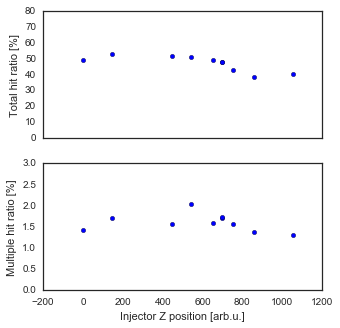

In [8]:
fig, (ax1, ax2) = subplots(2, 1, figsize=(5, 5), sharex=True)
ax1.scatter(Z, 100*nhits/ntots)
ax1.set_ylim(0, 80)
ax1.set_ylabel("Total hit ratio [%]")
ax2.scatter(Z, 100*nmuls/ntots)
ax2.set_ylim(0, 3)
ax2.set_ylabel("Multiple hit ratio [%]")
ax2.set_xlabel("Injector Z position [arb.u.]")
savefig("injz_vs_rates.png", dpi=400)

In [27]:
data_folder = "/Users/hantke/Work/Beamtimes/2017_flash/copied_data/"

tof_means = []
tof_means_hits = []
tof_means_misses = []
tof_means_muls = []
tof_traces = {}
gmds = {}
for r in runs:
    print r
    hitscore = read_hitscores(run_nr=r, ol=2, data_folder=data_folder)
    mulscore = read_mulscores(run_nr=r, ol=2, data_folder=data_folder)
    T = 70000
    tof = read_tof(run_nr=r, ol=2, data_folder=data_folder)
    print len(tof)
    gmd = read_gmd(run_nr=r, ol=2, data_folder=data_folder)
    gmd_lim = (70-5, 70+5)
    #gmd_lim = (0, 100)
    if (~isfinite(gmd)).sum() > 0:
        gmd[~isfinite(gmd)] = 0
    gmd_sel = (gmd >= gmd_lim[0]) * (gmd <= gmd_lim[1])
    hit_sel = hitscore > T
    T = 5
    mul_sel = mulscore > T
    tof_means.append(asarray(tof[gmd_sel,:], dtype="float64").mean(0))
    tof_means_hits.append(asarray(tof[gmd_sel*hit_sel,:], dtype="float64").mean(0))
    tof_means_misses.append(asarray(tof[gmd_sel*(~hit_sel),:], dtype="float64").mean(0))
    tof_means_muls.append(asarray(tof[gmd_sel*(mul_sel),:], dtype="float64").mean(0))
    tof_traces[r] = tof
    gmds[r] = gmd

255
8413
256
7262
257
5969
258
7130
259
3161
260
7740
262
7563
265
6705
266
5268
267
6434


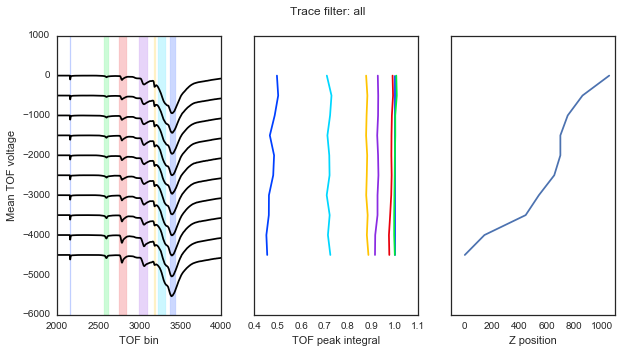

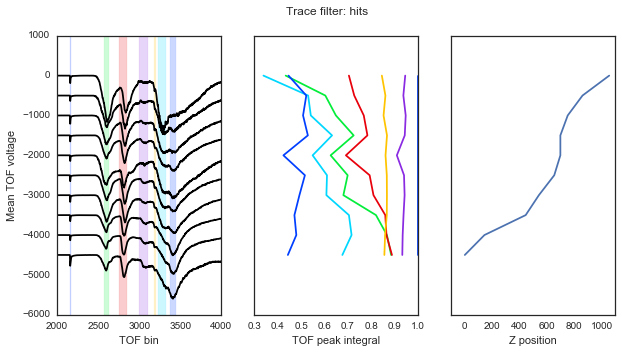

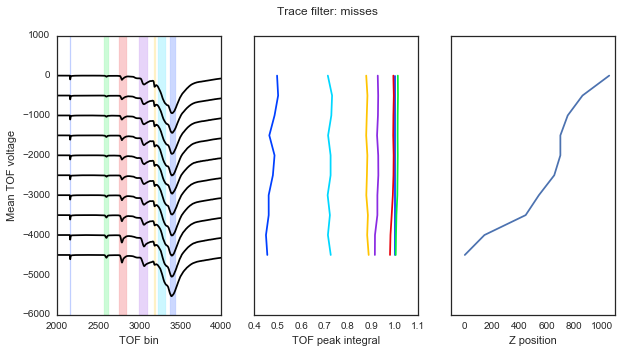

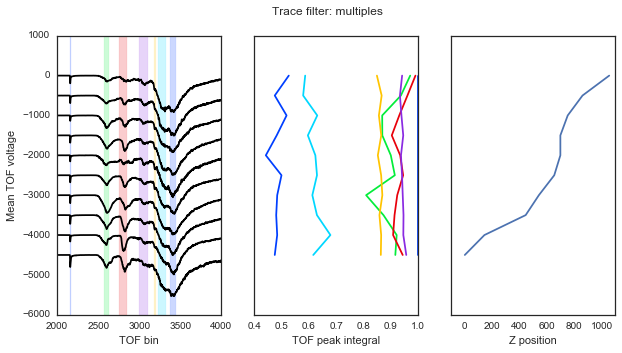

In [28]:
spans = [(2150,2165),(2575,2625),(2750, 2850),(3000, 3100),(3175, 3200),(3230, 3330),(3375, 3450)]
span_sums = zeros(shape=(len(runs), len(spans)))

for l,tof in zip(["all","hits","misses","multiples"],[tof_means, tof_means_hits, tof_means_misses, tof_means_muls]):
    fig, (ax1, ax2, ax3) = subplots(1, 3, figsize=(10, 5), sharey=True)
    fig.suptitle("Trace filter: %s" % l)
    
    ax3.plot(Z, -500*arange(len(runs)))
    ax3.set_xlim(-100, 1100)

    for i,tm in enumerate(tof):
        ax1.plot((tm-tm[0])-500*i, c="black")
        for k,(s_min,s_max) in enumerate(spans):
            span_sums[i,k] = tm[s_min:s_max].mean()
    
    colors = sns.color_palette("bright", len(spans))
    for (k,(s_min,s_max)) in enumerate(spans):
        ax1.axvspan(s_min, s_max, alpha=0.2, color=colors[k])
        ax2.plot(span_sums[:,k]/span_sums[:,0], -500*arange(len(runs)), color=colors[k])
    ax1.set_xlim(2000, 4000)
    ax1.set_xlabel("TOF bin")
    ax1.set_ylabel("Mean TOF voltage")

    ax2.set_xlabel("TOF peak integral")

    ax3.set_xlabel("Z position")
    fig.savefig("tof_%s.png" % l)

In [39]:
runs_S = {}
ii_ol3_S = {}
types = ["holography", "mimivirus", "cluster"]
titles = ["Mimivirus and Cluster", "Mimivirus", "Cluster"]
tofs_S = {}

# Holo
runs_S["holography"] = 253
ii_ol3_S["holography"] = [2557,1987,2558,2693,2597,2604,1963,2610,2048,1939,2157]

# Bio
runs_S["mimivirus"] = 253
ii_ol3_S["mimivirus"] = [1714,703,24,2517,2442,2721,1716,1980,1926,1726,1741,2203]

# Cluster
runs_S["cluster"] = 253
ii_ol3_S["cluster"] = [1557,171,851,193,1821,2013,1608,250,526,553]

for t in types:
    r = runs_S[t]
    ii_ol3 = ii_ol3_S[t]
    bids = [read_bunch_id(run_nr=r, ol=3)[i] for i in ii_ol3]
    ii_ol2 = [get_index_from_bunch_id(bunch_id=bid, run_nr=r, ol=2) for bid in bids]
    ii_ol2 = [i for i in ii_ol2 if i is not None]
    print len(ii_ol2)
    tofs_S[t] = asarray([read_tof(run_nr=r, i=i, ol=2) for i in ii_ol2], dtype="float64")

10
10
10


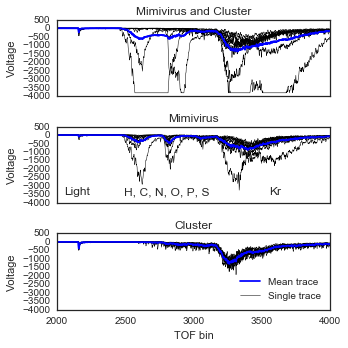

In [92]:
fig, axs = subplots(3, 1, figsize=(5,5), sharex=True, sharey=True)
for ax, tit, t in zip(axs,titles, types):
    trs = array(tofs_S[t], dtype="float64")
    for i in range(trs.shape[0]):
        trs[i,:] -= trs[i,0]
        #trs[i,:] /= abs(trs[i,:].sum())
    ax.plot(trs.mean(0)-len(trs)*0.0, color='blue')
    for i,tr in enumerate(trs):
        ax.plot(tr-i*0.0, lw=0.5, color='black')
        if i == 0 and tit == "Cluster":
            ax.legend(["Mean trace", "Single trace"], loc="lower right")
    ax.plot(trs.mean(0)-len(trs)*0.0, color='blue')
    ax.set_title(tit)
    ax.set_ylabel("Voltage")
ax.set_xlim(2000,4000)
#masses_el = ["H", "C", "N", "O", "P", "S", "Kr"]
#masses = array([1, 12, 14, 16, 31, 32, 83], dtype="float")
#for ax in axs:
#    ax.axvline(2145, ls="--", color="green", lw=0.5)
#    for m in masses:
#        ax.axvline(2145+m*2500/150., color="green", lw=0.5)
labels = {"Light": 2145,
          "H, C, N, O, P, S": 2800,
          "Kr": 3600,
          }

for l,pos in labels.items():
    axs[1].text(pos, -3500, l, ha="center")
ax.set_xlabel("TOF bin")

tight_layout()

savefig("tof_analysis.png", dpi=400)